In [1]:
import pandas as pd
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

In [2]:
# function to clean the data
# drop rows that contain na values
# change the date column do datetime objects
def clean_data(data):
    data = data.dropna()
    data.loc[:,('date')] = pd.to_datetime(data.loc[:,('date')])
    return data

# function to aggregate the data
# group by day and room
# compute all min, max and mean values for all air quality attributes
def aggregate(data):
    df = data.groupby([data['date'].dt.date, "location_uuid"]).agg(
        {
            "t_ambient": [min, max, 'mean'],
            "t_globe": [min, max, 'mean'],
            "hum_ambient": [min, max, 'mean'],
            "hum_globe": [min, max, 'mean'],
            "co2": [min, max, 'mean'],
            "tvoc": [min, max, 'mean'],
            "pm1": [min, max, 'mean'],
            "pm2_5": [min, max, 'mean'],
            "pm10": [min, max, 'mean'],
            "aerosol_small": [min, max, 'mean'],
            "aerosol_large": [min, max, 'mean']
        }
    )
    return df

# function to aggregate the data
# group by day and room
# compute all min, max and mean values for all air quality attributes
def aggregate_hour(data):
    df = data.groupby([data['date'].dt.date, data['date'].dt.hour,"location_uuid"]).agg(
        {
            "t_ambient": [min, max, 'mean'],
            "t_globe": [min, max, 'mean'],
            "hum_ambient": [min, max, 'mean'],
            "hum_globe": [min, max, 'mean'],
            "co2": [min, max, 'mean'],
            "tvoc": [min, max, 'mean'],
            "pm1": [min, max, 'mean'],
            "pm2_5": [min, max, 'mean'],
            "pm10": [min, max, 'mean'],
            "aerosol_small": [min, max, 'mean'],
            "aerosol_large": [min, max, 'mean']
        }
    )
    return df

#function to add target column to data
#data has to be only on a particular room
def grouped_targets(df):
    df_x = df[:len(df)-6].reset_index()

    df_co2       = df[6:len(df)].reset_index()["co2"]
    df_t_ambient = df[6:len(df)].reset_index()["t_ambient"]
    df_tvoc      = df[6:len(df)].reset_index()["tvoc"]

    df_x["co2_30min"]       = df_co2
    df_x["t_ambient_30min"] = df_t_ambient
    df_x["tvoc_30min"]      = df_tvoc

    df_x = df_x.drop(["date", "location_uuid", "index"], axis=1)
    return df_x

In [ ]:
# read and clean client 3 data
client_3 = pd.read_csv('Export/client_3.csv')
client_3 = clean_data(client_3)

In [3]:
# read and clean client 3 data
calc_client_3 = pd.read_csv('Export/calc_measures_client_3.csv')
calc_client_3 = calc_client_3.drop(['Unnamed: 0', 'Date', 'Location', 'YYYYMMDD_x', 'YYYYMMDD_y', 'HH', 'MM', '# STN', 'DATE'], axis=1)
calc_client_3 = clean_data(calc_client_3)

In [4]:
#split client 3 data on rooms
client_3_rooms = [y for x, y in calc_client_3.groupby('location_uuid', as_index=False)]

#compute targets per room and append to dataframe
df_3 = pd.DataFrame()
for room in client_3_rooms:
    df_3 = df_3.append(grouped_targets(room))

<AxesSubplot:>

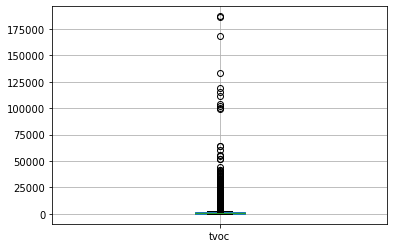

In [5]:
df_3.boxplot('tvoc')

In [6]:
q75,q25 = np.percentile(df_3.loc[:,'tvoc'],[75,25])
intr_qr = q75-q25

max_tvoc = q75+(1.5*intr_qr)
min_tvoc = q25-(1.5*intr_qr)

df_3 = df_3.loc[(df_3['tvoc'] < max_tvoc) & (df_3['tvoc'] > min_tvoc)]

<AxesSubplot:>

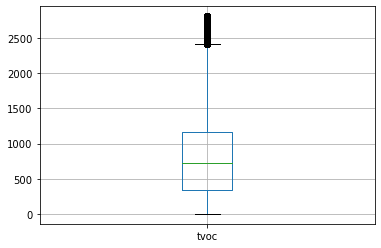

In [7]:
df_3.boxplot('tvoc')

In [8]:
norm_layer = layers.Normalization()
norm_layer.adapt(df_3.drop(['co2_30min', 't_ambient_30min', 'tvoc_30min'], axis=1))

In [9]:
steps_backwards = 3
steps_forward   = 6

data_X = norm_layer(df_3.drop(['co2_30min', 't_ambient_30min', 'tvoc_30min'], axis=1))
data_X = np.array(data_X)
data_Y = df_3[['co2_30min', 't_ambient_30min', 'tvoc_30min']][steps_backwards:len(df_3)-steps_forward]

series_reshaped_X =  np.array([data_X[i:i + steps_backwards].copy() for i in range(len(df_3) - (steps_backwards+steps_forward))])

In [10]:
#create train test split
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(series_reshaped_X, data_Y, 
    test_size=0.33, random_state=42)

In [13]:
#rnn model
rnn_model = keras.Sequential()
rnn_model.add(layers.LSTM(32, input_shape=(3, 44)))
rnn_model.add(layers.Dense(3))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                9856      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 9,955
Trainable params: 9,955
Non-trainable params: 0
_________________________________________________________________


In [14]:
rnn_model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    # Loss function to minimize
    loss=keras.losses.MeanAbsoluteError(),
    # List of metrics to monitor
    metrics=[]
)

In [11]:
rnn_model = keras.models.load_model('Models/rnn_model')

d:\Anaconda\lib\site-packages\keras\saving\saved_model\load.py:115: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  metadata.ParseFromString(file_content)


In [22]:
history_rnn = rnn_model.fit(
    X_train_rnn,
    y_train_rnn,
    batch_size=64,
    epochs=128,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test_rnn, y_test_rnn),
)

Epoch 1/128
1174/1174 [==============================] - 4s 4ms/step - loss: 44.2764 - val_loss: 48.4204
Epoch 2/128
1174/1174 [==============================] - 4s 4ms/step - loss: 44.2840 - val_loss: 48.3486
Epoch 3/128
1174/1174 [==============================] - 4s 4ms/step - loss: 44.2766 - val_loss: 48.3572
Epoch 4/128
1174/1174 [==============================] - 4s 4ms/step - loss: 44.2642 - val_loss: 48.4577
Epoch 5/128
1174/1174 [==============================] - 4s 4ms/step - loss: 44.2470 - val_loss: 48.3621
Epoch 6/128
1174/1174 [==============================] - 4s 4ms/step - loss: 44.2368 - val_loss: 48.5096
Epoch 7/128
1174/1174 [==============================] - 4s 4ms/step - loss: 44.2282 - val_loss: 48.3800
Epoch 8/128
1174/1174 [==============================] - 4s 4ms/step - loss: 44.2428 - val_loss: 48.3640
Epoch 9/128
1174/1174 [==============================] - 4s 4ms/step - loss: 44.2171 - val_loss: 48.3528
Epoch 10/128
1174/1174 [==============================]

In [19]:
rnn_model.save('Models/rnn_model', save_format='tf')

INFO:tensorflow:Assets written to: Models/rnn_model\assets


INFO:tensorflow:Assets written to: Models/rnn_model\assets


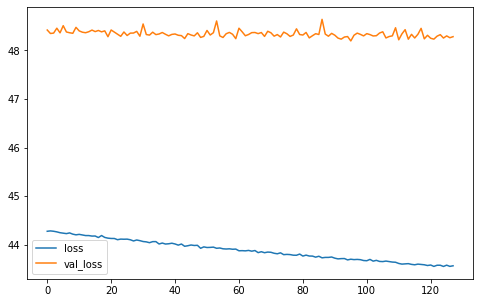

In [23]:
pd.DataFrame(history_rnn.history).plot(figsize=(8,5))
plt.show()

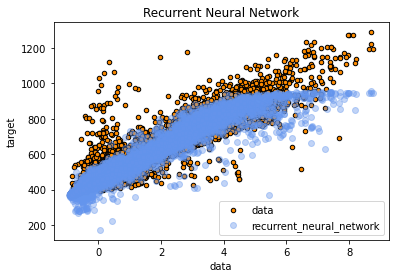

In [24]:
y_pred_rnn = pd.DataFrame(rnn_model.predict(X_test_rnn))

#16 = co2, 17 = tvoc, 12 = t_ambient
#model 0 = co2, 1 = t_ambient, 2 = tvoc
plt.figure()
plt.scatter(X_test_rnn[:,2,16], y_test_rnn['co2_30min'], s=20, edgecolor="black", c="darkorange", label="data")
plt.scatter(X_test_rnn[:,2,16], y_pred_rnn[0], color="cornflowerblue", label="recurrent_neural_network", alpha=0.4)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Recurrent Neural Network")
plt.legend()
plt.show()

In [25]:
print(np.sort(y_pred_rnn[0]))

[173.14337 224.75385 268.35657 ... 948.8828  949.7396  954.572  ]


In [26]:
#create train test split
X_train, X_test, y_train, y_test = train_test_split(df_3.drop(['co2_30min', 't_ambient_30min', 'tvoc_30min'], axis=1), 
    df_3[['co2_30min', 't_ambient_30min', 'tvoc_30min']], 
    test_size=0.33, random_state=42)

In [27]:
#tree regression model
tree_regression = DecisionTreeRegressor(random_state=42)
tree_regression.fit(X_train, y_train)
y_pred_tree_regression = pd.DataFrame(tree_regression.predict(X_test))
mean_absolute_error(y_test, y_pred_tree_regression)

61.22109324469155

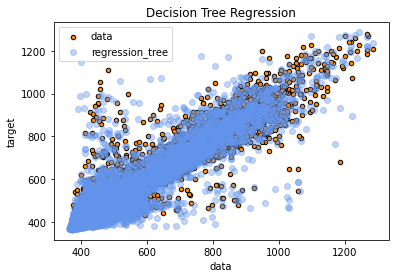

In [28]:
plt.figure()
plt.scatter(X_test['co2'], y_test['co2_30min'], s=20, edgecolor="black", c="darkorange", label="data")
plt.scatter(X_test['co2'], y_pred_tree_regression[0], color="cornflowerblue", label="regression_tree", alpha=0.4)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [29]:
#construct neural network model
nn_model_client_3 = keras.Sequential()
nn_model_client_3.add(keras.Input(shape=(X_train.shape[1],)))
nn_model_client_3.add(layers.BatchNormalization(axis=1))
nn_model_client_3.add(layers.Dense(128, activation="relu"))
nn_model_client_3.add(layers.Dense(128, activation="relu"))
nn_model_client_3.add(layers.Dense(3))
nn_model_client_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 44)               176       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               5760      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 22,835
Trainable params: 22,747
Non-trainable params: 88
_________________________________________________________________


In [30]:
nn_model_client_3.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    # Loss function to minimize
    loss=keras.losses.MeanAbsoluteError(),
    # List of metrics to monitor
    metrics=[],
)

In [34]:
history = nn_model_client_3.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=32,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, y_test),
)

Epoch 1/32
1174/1174 [==============================] - 3s 3ms/step - loss: 61.4128 - val_loss: 47.4839
Epoch 2/32
1174/1174 [==============================] - 4s 3ms/step - loss: 61.4571 - val_loss: 46.8550
Epoch 3/32
1174/1174 [==============================] - 4s 3ms/step - loss: 60.8337 - val_loss: 46.3962
Epoch 4/32
1174/1174 [==============================] - 3s 3ms/step - loss: 60.9737 - val_loss: 46.8466
Epoch 5/32
1174/1174 [==============================] - 3s 3ms/step - loss: 61.2925 - val_loss: 47.4053
Epoch 6/32
1174/1174 [==============================] - 3s 3ms/step - loss: 61.2036 - val_loss: 46.8832
Epoch 7/32
1174/1174 [==============================] - 3s 3ms/step - loss: 60.1641 - val_loss: 46.4560
Epoch 8/32
1174/1174 [==============================] - 3s 3ms/step - loss: 60.6453 - val_loss: 48.1456
Epoch 9/32
1174/1174 [==============================] - 3s 2ms/step - loss: 60.4668 - val_loss: 48.3157
Epoch 10/32
1174/1174 [==============================] - 3s 3ms/

In [32]:
nn_model_client_3.save('Models/nn_model_client_3', save_format='tf')

INFO:tensorflow:Assets written to: Models/nn_model_client_3\assets


INFO:tensorflow:Assets written to: Models/nn_model_client_3\assets


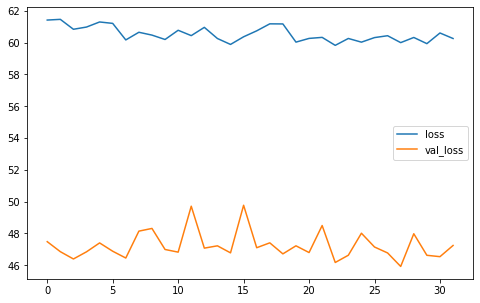

In [35]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [36]:
y_pred_nn = pd.DataFrame(nn_model_client_3.predict(X_test))

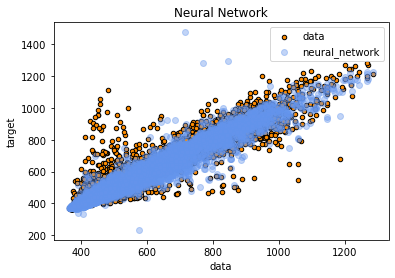

In [37]:
plt.figure()
plt.scatter(X_test['co2'], y_test['co2_30min'], s=20, edgecolor="black", c="darkorange", label="data")
plt.scatter(X_test['co2'], y_pred_nn[0], color="cornflowerblue", label="neural_network", alpha=0.4)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Neural Network")
plt.legend()
plt.show()

In [38]:
print(np.sort(y_pred_nn[0]))

[ 234.16887  331.0309   340.2713  ... 1280.5925  1294.2314  1473.6931 ]
